In [2]:
from nptdms import TdmsFile
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
tdms_path = r'C:\Users\maksymilianm\Dropbox (UCL - SWC)\Project_spiders\Raw_data\def_behav_probe\29.10.19_sp6_LDR.tdms'
tdms_file = TdmsFile(tdms_path)

photodiode_raw = tdms_file.group_channels('Photodiode')[0].data
spider_camera_input = tdms_file.group_channels('spider_camera_input')[0].data
t0 = tdms_file.group_channels('t0')[0].data
plt.plot(photodiode_raw)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\maksymilianm\\Dropbox (UCL - SWC)\\Project_spiders\\Raw_data\\def_behav_probe\\29.10.19_sp6_LDR.tdms'

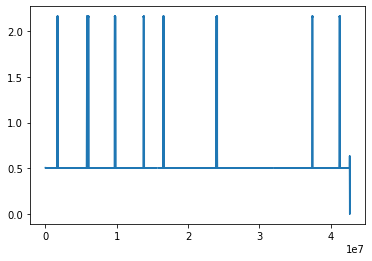

In [4]:
low_pulse_indexes = np.where(photodiode_raw < 0.1)
photodiode_smoothed = photodiode_raw

for i in low_pulse_indexes:
    photodiode_smoothed[i] = photodiode_smoothed[i-1]

plt.plot(photodiode_smoothed)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, resample, wiener, gaussian
from scipy.ndimage import filters
from collections import namedtuple
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
def find_peaks_in_signal(signal, time_limit, th, above=True):
    """[Function to find the start of square peaks in a time series. 
    Useful for example to find frame starts or stim starts in analog input data]
    Arguments:
        signal {[np.array]} -- [the time series to be analysd]
        time_limit {[float]} -- [min time inbetween peaks]
        th {[float]} -- [where to threshold the signal to identify the peaks]
    Returns:
        [np.ndarray] -- [peak starts times]
    """
    if above:
        above_th = np.where(signal>th)[0]
    else:
        above_th = np.where(signal<th)[0]
    if not np.any(above_th): return np.array([])
    peak_starts = [x for x,d in zip(above_th, np.diff(above_th)) if d > time_limit]
    # add the first and last above_th times to make sure all frames are included
    peak_starts.insert(0, above_th[0])
    peak_starts.append(above_th[-1])
    # we then remove the second item because it corresponds to the end of the first peak
    peak_starts.pop(1)
    return np.array(peak_starts)
def find_visual_stimuli(data, th, sampling_rate):
    """ [Filter the data to remove high freq noise, then take the diff and thereshold to find changes]
        Arguments:
            data {[np.ndarray]} -- [1D numpy array with sample data (extracted from TDMS)]
            th {[int]} -- [Threshold]
            sampling_rate {[int]} -- [sampling rate of experiment]
    """
    filtered  = butter_lowpass_filter(data, 75, int(sampling_rate/2))
    d_filt = np.diff(filtered)
    # find start and ends of stimuli (when it goes above and under threhsold)
    ends = find_peaks_in_signal(d_filt, 50,  -0.0002, above=False )[1:]
    starts = find_peaks_in_signal(d_filt, 50, 0.0002, above=True )[1:]
    # if the number of starts and ends doesnt match something went wrong
    if not len(starts) == len(ends):
        if abs(len(starts)-len(ends))>1: raise ValueError("Too large error during detection: s:{} e{}".format(len(starts), len(ends)))
        print("Something went wrong: {} - starts and {} - ends".format(len(starts), len(ends)))
        # ? Fo1r debugging
        f, ax = plt.subplots()
        ax.plot(filtered, color='r')
        ax.plot(butter_lowpass_filter(np.diff(filtered), 75, int(sampling_rate/2)), color='g')
        ax.scatter(starts, [0.25 for i in starts], c='r')
        ax.scatter(ends, [0 for i in ends], c='k')
        plt.show()
        to_elim = int(input("Which one to delete "))
        if len(starts)  > len(ends):
            starts = np.delete(starts, to_elim)
        else:
            ends = np.delete(ends, to_elim)
    assert len(starts) == len(ends), "cacca"
    # Return as a list of named tuples
    stim = namedtuple("stim", "start end")
    stimuli =[stim(s,e) for s,e in zip(starts, ends)]
    for s,e in stimuli:  # check that the end is after the start
       if e < s: raise ValueError("Wrong stimuli detection")
    return stimuli


In [13]:
tdms_path = r'C:\Users\maksymilianm\Dropbox (UCL - SWC)\Project_spiders\Raw_data\def_behav_probe\29.10.19_sp4_LDR.tdms'
tdms_file = TdmsFile(tdms_path)

photodiode_raw = tdms_file.group_channels('Photodiode')[0].data

low_pulse_indexes = np.where(photodiode_raw < 0.1)
photodiode_smoothed = photodiode_raw

for i in low_pulse_indexes:
    photodiode_smoothed[i] = photodiode_smoothed[i-1]

Something went wrong: 10 - starts and 11 - ends


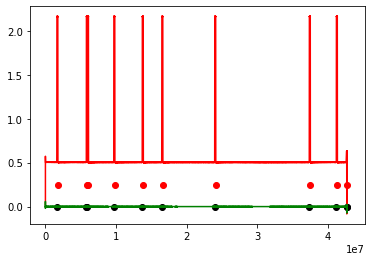

Which one to delete -1


ValueError: Wrong stimuli detection

In [14]:
find_visual_stimuli(photodiode_smoothed, 1.5, 2500)

In [4]:
tdms_path = r'C:\Users\maksymilianm\Dropbox (UCL - SWC)\Project_spiders\Raw_data\def_behav_probe\30.10.19_sp6_LDR.tdms'
tdms_file = TdmsFile(tdms_path)

photodiode_raw = tdms_file.group_channels('Photodiode')[0].data
spider_camera_input = tdms_file.group_channels('spider_camera_input')[0].data
low_pulse_indexes = np.where(photodiode_raw < 0.1)
photodiode_smoothed = photodiode_raw

for i in low_pulse_indexes:
    photodiode_smoothed[i] = photodiode_smoothed[i-1]

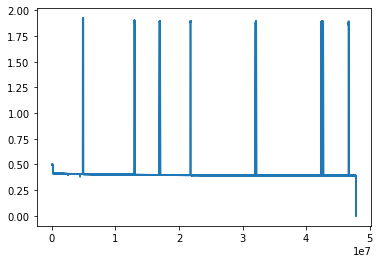

In [17]:
plt.plot(photodiode_smoothed)

In [46]:
find_visual_stimuli(photodiode_smoothed, 1.5, 25000)

[stim(start=4841371, end=4978399),
 stim(start=12911629, end=13049168),
 stim(start=16917014, end=17054558),
 stim(start=21742880, end=21880425),
 stim(start=32024592, end=32162140),
 stim(start=42363306, end=42500863),
 stim(start=42555304, end=42692852),
 stim(start=46632187, end=46769743),
 stim(start=47845090, end=47845165)]

In [35]:
th = 1.5
sampling_rate = 25000
filtered  = butter_lowpass_filter(photodiode_smoothed[0:46000000], 75, int(sampling_rate/2))
d_filt = np.diff(filtered)

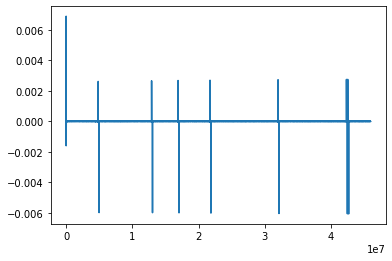

In [36]:
plt.plot(d_filt)

In [28]:
len(photodiode_smoothed)

47857250

# Finding frame onsets to correlate them with sampling numbers

(0, 2500)

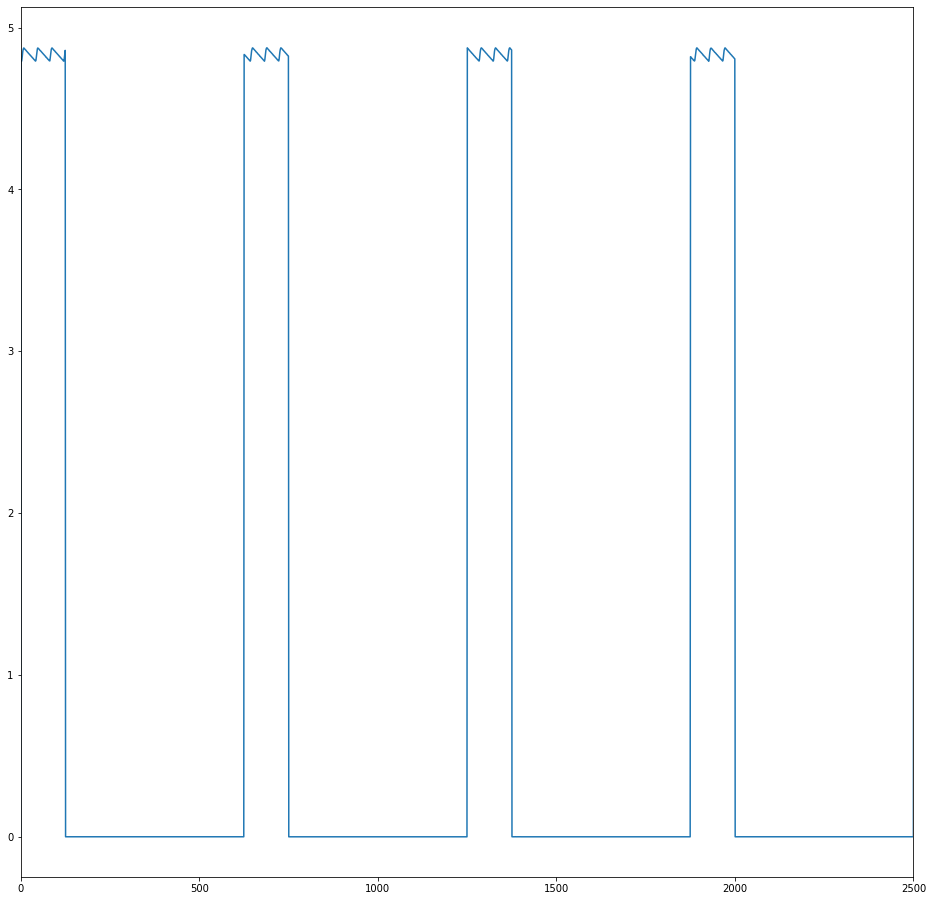

In [77]:
plt.figure(figsize=(16, 16))
plt.plot(spider_camera_input)
plt.xlim(0, 2500)

In [49]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)

[]

In [53]:
find_visual_stimuli(spider_camera_input, 1.5, 2500)

[]

In [54]:
find_visual_stimuli(spider_camera_input, 0.5, 2500)

[]

# changed time limit for both starts and ends 10000 --> 1000

In [57]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)

[]

# changed time limit for both starts and ends 1000 --> 100

In [59]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)


ValueError: Too large error during detection: s:76553 e76551

# changed time limit for both starts and ends 100 --> 500

In [61]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)

[]

# changed time limit for both starts and ends 500 --> 300

In [64]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)


[]

# changed time limit for both starts and ends 300 --> 150

In [66]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)

ValueError: Too large error during detection: s:0 e76551

# changed time limit for both starts and ends 150 --> 50


Something went wrong: 229656 - starts and 229655 - ends


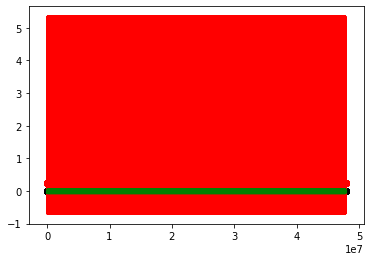

Which one to delete 0


ValueError: Wrong stimuli detection

In [69]:
find_visual_stimuli(spider_camera_input, 1.5, 25000)

In [80]:
print(len(spider_camera_input) - 2500)


47854750


(47854750, 47857250)

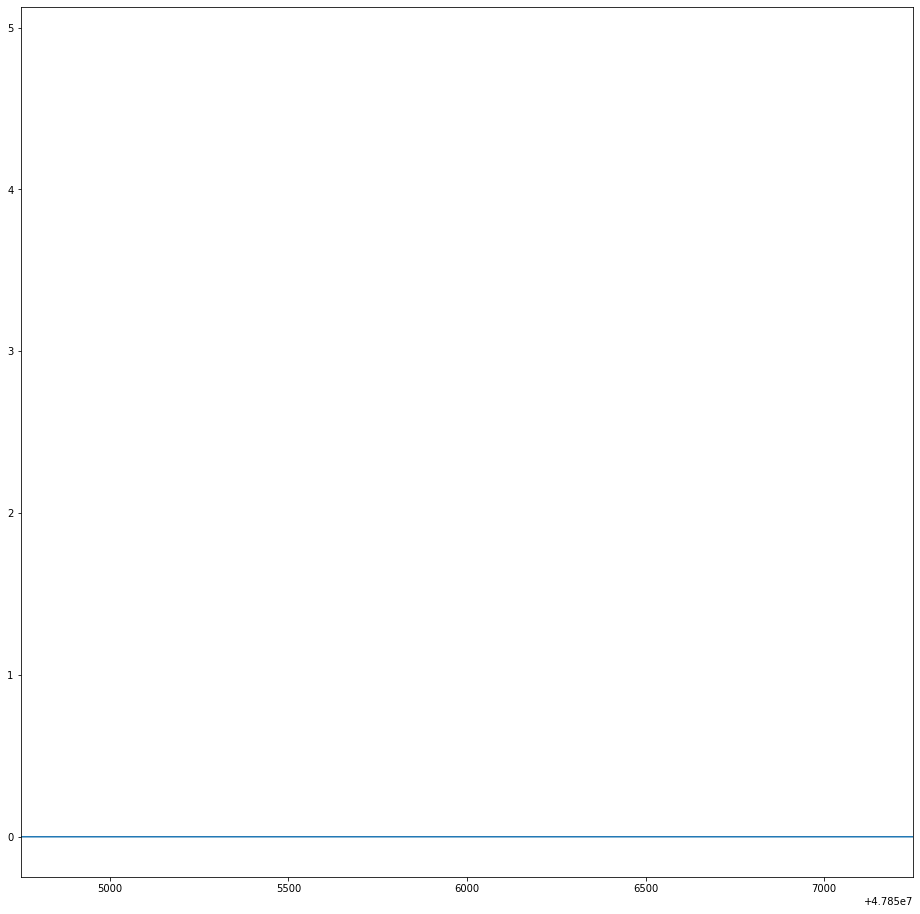

In [81]:
plt.figure(figsize=(16, 16))
plt.plot(spider_camera_input)
plt.xlim(47854750, 47857250)

In [6]:
find_visual_stimuli(photodiode_smoothed, 1.5, 25000)

NameError: name 'find_visual_stimuli' is not defined